In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar
import astropy.cosmology as apc
import matplotlib.colors as mpc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is almost final list of particles ids, but not yet
    
    LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    icut2 = np.where(LostNow==-1)[0]
    IndexT_near_ = IndexT_near[icut2]
    
    icut3 = np.where(LostNow!=-1)[0]
    IndexT_near_cutted = IndexT_near[icut3]
    
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near_]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near_]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_]

    NearCoord_cutted = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near_cutted]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    XC, YC, ZC = NearCoord_cutted[:,0] - posGal[0], NearCoord_cutted[:,1] - posGal[1], NearCoord_cutted[:,2] - posGal[2]
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2 + velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    xCv, yCv, zCv = [], [], []
    xCc, yCc, zCc = [], [], []
    
    for x, y, z in zip(XC, YC, ZC):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xCv.append(dV[0])
        yCv.append(dV[1])
        zCv.append(dV[2])
    
        xCc.append(dC[0])
        yCc.append(dC[1])
        zCc.append(dC[2])
        
    xCv, yCv, zCv = np.array(xCv), np.array(yCv), np.array(zCv)
    xCc, yCc, zCc = np.array(xCc), np.array(yCc), np.array(zCc)
    
    datoff = np.array([fofID]*IndexT_near_cutted.size)
    
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    cosCC = xCc/np.sqrt(xCc**2.+yCc**2.+zCc**2.)
    cosCV = xCv/np.sqrt(xCv**2.+yCv**2.+zCv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances, cosCV, cosCC, datoff

In [7]:
# ok, lets test this
gal1, cen1 = 4470, 4469
gal2, cen2 = 4471, 4469

cosV_1, cosC_1, GasMasses_1, GassAbundances_1, cosCV_1, cosCC_1, datoff_1 = getAllLastP(gal1, cen1)
cosV_2, cosC_2, GasMasses_2, GassAbundances_2, cosCV_2, cosCC_2, datoff_2 = getAllLastP(gal2, cen2)

offst_1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal1].astype('int')
STMass_1 = sim['SnapNumber_128/PartType4/Masses'][offst_1[0]:offst_1[1]]
STM_1 = np.sum(STMass_1)

offst_2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal2].astype('int')
STMass_2 = sim['SnapNumber_128/PartType4/Masses'][offst_2[0]:offst_2[1]]
STM_2 = np.sum(STMass_2)

Text(0, 0.5, 'Gas Mass/Stellar Mass')

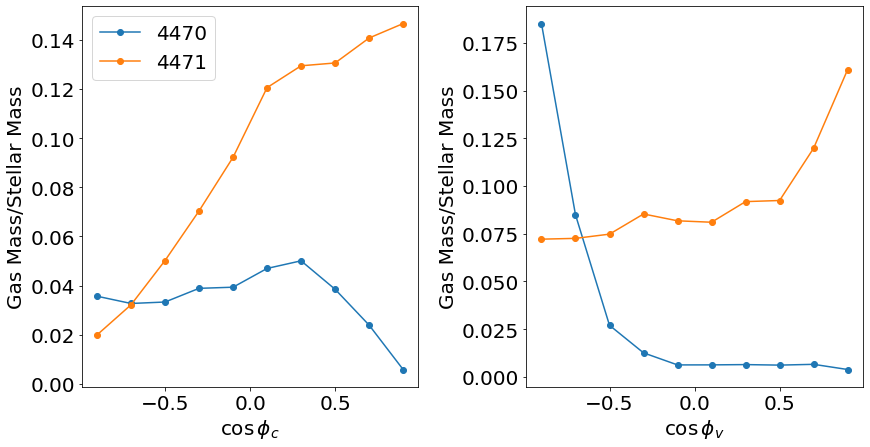

In [8]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.32)

Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

data_1 = GasMasses_1
weight_1 = 1./STM_1

data_2 = GasMasses_2
weight_2 = 1./STM_2

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(cosC_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(cosV_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))

sumC_2, binsC_2, zipC_2 = sp.binned_statistic(cosC_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(cosV_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV_1[:-1]+binsV_1[1:])

pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')
pl.plot(x_x, sumC_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumC_2, marker='o', label='{}'.format(gal2))
pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)
 
# pl.errorbar(x_x, sumV, yerr=errV, marker='o')
pl.plot(x_x, sumV_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumV_2, marker='o', label='{}'.format(gal2))

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
pl.ylabel('Gas Mass/Stellar Mass')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

# pl.savefig('paperGraphs/phiAll.pdf')

In [9]:
# ok, lets test this
gal1, cen1 = 4473, 4469
gal2, cen2 = 4474, 4469

cosV_1, cosC_1, GasMasses_1, GassAbundances_1, cosCV_1, cosCC_1, datoff_1 = getAllLastP(gal1, cen1)
cosV_2, cosC_2, GasMasses_2, GassAbundances_2, cosCV_2, cosCC_2, datoff_2 = getAllLastP(gal2, cen2)

offst_1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal1].astype('int')
STMass_1 = sim['SnapNumber_128/PartType4/Masses'][offst_1[0]:offst_1[1]]
STM_1 = np.sum(STMass_1)

offst_2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal2].astype('int')
STMass_2 = sim['SnapNumber_128/PartType4/Masses'][offst_2[0]:offst_2[1]]
STM_2 = np.sum(STMass_2)

Text(0, 0.5, 'Gas Mass/Stellar Mass')

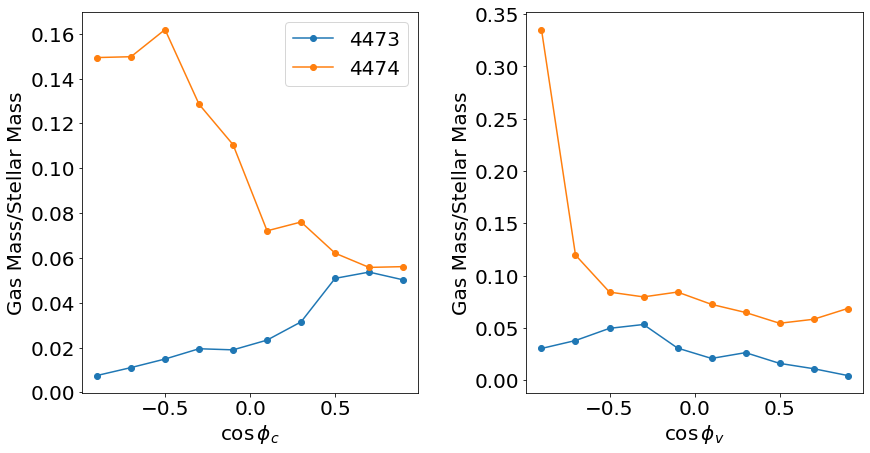

In [10]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.32)

Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

data_1 = GasMasses_1
weight_1 = 1./STM_1

data_2 = GasMasses_2
weight_2 = 1./STM_2

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(cosC_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(cosV_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))

sumC_2, binsC_2, zipC_2 = sp.binned_statistic(cosC_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(cosV_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV_1[:-1]+binsV_1[1:])

pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')
pl.plot(x_x, sumC_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumC_2, marker='o', label='{}'.format(gal2))
pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)
 
# pl.errorbar(x_x, sumV, yerr=errV, marker='o')
pl.plot(x_x, sumV_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumV_2, marker='o', label='{}'.format(gal2))

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
pl.ylabel('Gas Mass/Stellar Mass')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

# pl.savefig('paperGraphs/phiAll.pdf')

In [11]:
# ok, lets test this
gal1, cen1 = 4471, 4469
gal2, cen2 = 4478, 4469

cosV_1, cosC_1, GasMasses_1, GassAbundances_1, cosCV_1, cosCC_1, datoff_1 = getAllLastP(gal1, cen1)
cosV_2, cosC_2, GasMasses_2, GassAbundances_2, cosCV_2, cosCC_2, datoff_2 = getAllLastP(gal2, cen2)

offst_1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal1].astype('int')
STMass_1 = sim['SnapNumber_128/PartType4/Masses'][offst_1[0]:offst_1[1]]
STM_1 = np.sum(STMass_1)

offst_2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal2].astype('int')
STMass_2 = sim['SnapNumber_128/PartType4/Masses'][offst_2[0]:offst_2[1]]
STM_2 = np.sum(STMass_2)

Text(0, 0.5, 'Gas Mass/Stellar Mass')

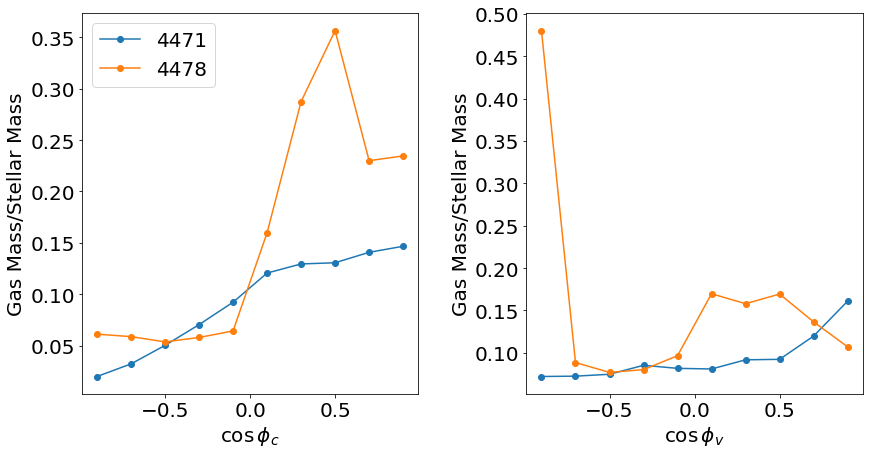

In [12]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.32)

Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

data_1 = GasMasses_1
weight_1 = 1./STM_1

data_2 = GasMasses_2
weight_2 = 1./STM_2

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(cosC_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(cosV_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))

sumC_2, binsC_2, zipC_2 = sp.binned_statistic(cosC_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(cosV_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV_1[:-1]+binsV_1[1:])

pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')
pl.plot(x_x, sumC_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumC_2, marker='o', label='{}'.format(gal2))
pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)
 
# pl.errorbar(x_x, sumV, yerr=errV, marker='o')
pl.plot(x_x, sumV_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumV_2, marker='o', label='{}'.format(gal2))

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
pl.ylabel('Gas Mass/Stellar Mass')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

# pl.savefig('paperGraphs/phiAll.pdf')

In [13]:
# ok, lets test this
gal1, cen1 = 4341, 4337
gal2, cen2 = 4476, 4469

cosV_1, cosC_1, GasMasses_1, GassAbundances_1, cosCV_1, cosCC_1, datoff_1 = getAllLastP(gal1, cen1)
cosV_2, cosC_2, GasMasses_2, GassAbundances_2, cosCV_2, cosCC_2, datoff_2 = getAllLastP(gal2, cen2)

offst_1 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal1].astype('int')
STMass_1 = sim['SnapNumber_128/PartType4/Masses'][offst_1[0]:offst_1[1]]
STM_1 = np.sum(STMass_1)

offst_2 = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal2].astype('int')
STMass_2 = sim['SnapNumber_128/PartType4/Masses'][offst_2[0]:offst_2[1]]
STM_2 = np.sum(STMass_2)

Text(0, 0.5, 'Gas Mass/Stellar Mass')

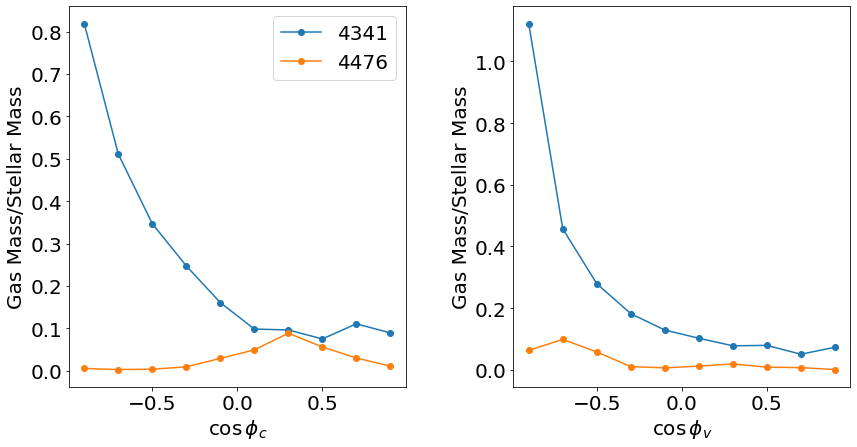

In [14]:
pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.32)

Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

data_1 = GasMasses_1
weight_1 = 1./STM_1

data_2 = GasMasses_2
weight_2 = 1./STM_2

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(cosC_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(cosV_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))

sumC_2, binsC_2, zipC_2 = sp.binned_statistic(cosC_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(cosV_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

x_x = .5*(binsV_1[:-1]+binsV_1[1:])

pl.subplot(1, 2, 1)

# pl.errorbar(x_x, sumC, yerr=errC, marker='o')
pl.plot(x_x, sumC_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumC_2, marker='o', label='{}'.format(gal2))
pl.legend(loc='best')

pl.xlabel('$\cos\,\phi_c$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)
 
# pl.errorbar(x_x, sumV, yerr=errV, marker='o')
pl.plot(x_x, sumV_1, marker='o', label='{}'.format(gal1))
pl.plot(x_x, sumV_2, marker='o', label='{}'.format(gal2))

pl.xlabel('$\cos\,\phi_v$')
# pl.ylabel('Time since stripping/Gyrs')
# pl.ylabel('Temperature/K')
pl.ylabel('Gas Mass/Stellar Mass')
# pl.ylabel('[Fe/H]')
# pl.ylabel('SFR$/(M_{\odot} yr^{-1})$')

# pl.savefig('paperGraphs/phiAll.pdf')